In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
folder_path = r"dataset" #directory for image dataset
categories = ["car","no_car"] # name of folder for each categories

In [3]:
data = [] # array to store image data
labels = [] # array to store image labels as in mask or no mask

In [4]:
for sub_folders in categories: #loop through each foler
    file_location = os.path.join(folder_path, sub_folders) #set path as mask or no_mask according to the value of i
    for image_names in os.listdir(file_location): # loop thorough all the images in each file location
        img_path = os.path.join (file_location, image_names)#extract the image according to name in the folder 
        image = load_img(img_path, target_size = (224,224)) #resize the image
        image = img_to_array (image) #convert image to array
        image = preprocess_input (image) #convert image array to adequaten data type 
        data.append (image) #push the image array into the data array
        labels.append (sub_folders) # push the labels name into the labels array

In [5]:
labels = LabelBinarizer().fit_transform(labels) # convert categorical data to numpy array
labels = to_categorical(labels)  # convert to numpy array to binary class matrix
data = np.array(data, dtype="float32") # convert to numpy array
labels = np.array(labels) # convert to numpy array

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)
# split data into training and testing dataset at a ratio of 80:20 and dividing the data into subgroups before shuffling the dataset

In [7]:
augment_image = ImageDataGenerator (
    rotation_range = 20, # rotate random image at 20 degree
    zoom_range = 0.15, # zoom in or zoom out image from 0 to 0.15 scale
    width_shift_range = 0.2, # horizontally shift random image
    height_shift_range = 0.2, # vertically shift random image
    shear_range = 0.15, # distord image along an axis
    horizontal_flip = True, #randomly flip images upside down
    fill_mode = "nearest" # replace empty area with nearest pixel value when pixel move outside the image 
)

In [8]:
learn_rate = 0.0001 # assign learning rate
epoch = 20 # run 20 passes through the training dataset
batch_sizes = 32 # assign 32 number of sample processed before model is updated 
opt = Adam(learning_rate=learn_rate, decay=learn_rate / 20) # use Adam optimizer with a learning rate of 0.0001

In [9]:
image_size = (224, 224, 3) # declare size of image
input_model = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=image_size)) # construct the model

9420800/9406464 [==============================] - 1s 0us/step


In [10]:
output_model = input_model.output # duplicate the output of model
output_model = AveragePooling2D(pool_size=(7, 7))(output_model) # calculate average for each patch of feature map
output_model = Flatten(name="flatten")(output_model) # convert into single dimension 
output_model = Dense(128, activation="relu")(output_model) # use relu activation function
output_model = Dropout(0.5)(output_model) # randomly set input unit to 0.5
output_model = Dense(2, activation="softmax")(output_model) # use softmax activation function

In [11]:
input_model.trainable = False # freeze the convolutional layers to use the base model as a feature extractor
model = Model(inputs=input_model.input, outputs=output_model) # place feature class on top of input_model
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"]) # compile the model using the declared variables

In [12]:
cnn_model = model.fit(
    augment_image.flow(X_train, y_train), # fit in distorted data into the model
    steps_per_epoch=len(X_train) // batch_sizes, #divide training dataset based on batch size
    validation_data=(X_test, y_test), #divide validation dataset based on batch size
    validation_steps=len(X_test) // batch_sizes,#divide validation dataset based on batch size 
    epochs=epoch) #declare number of epochs

Epoch 1/20
18/18 [==============================] - 17s 407ms/step - loss: 0.6501 - accuracy: 0.6728 - val_loss: 0.3740 - val_accuracy: 0.9379
Epoch 2/20
18/18 [==============================] - 6s 325ms/step - loss: 0.4133 - accuracy: 0.8647 - val_loss: 0.2605 - val_accuracy: 0.9448
Epoch 3/20
18/18 [==============================] - 6s 315ms/step - loss: 0.3105 - accuracy: 0.9068 - val_loss: 0.2022 - val_accuracy: 0.9448
Epoch 4/20
18/18 [==============================] - 7s 380ms/step - loss: 0.2742 - accuracy: 0.9177 - val_loss: 0.1800 - val_accuracy: 0.9586
Epoch 5/20
18/18 [==============================] - 7s 380ms/step - loss: 0.2374 - accuracy: 0.9287 - val_loss: 0.1568 - val_accuracy: 0.9586
Epoch 6/20
18/18 [==============================] - 6s 347ms/step - loss: 0.2227 - accuracy: 0.9360 - val_loss: 0.1490 - val_accuracy: 0.9586
Epoch 7/20
18/18 [==============================] - 8s 420ms/step - loss: 0.1831 - accuracy: 0.9415 - val_loss: 0.1296 - val_accuracy: 0.9586
Epoch

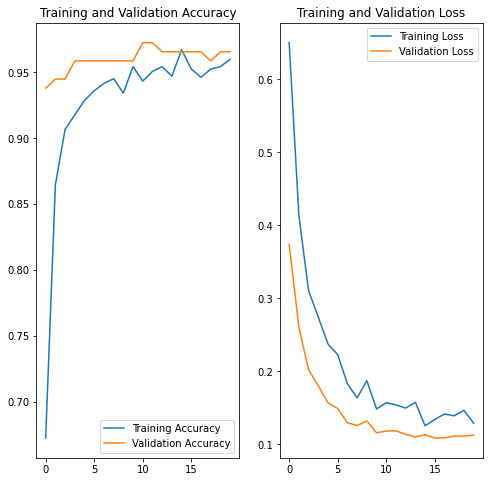

In [13]:
acc = cnn_model.history['accuracy'] # assign accuracy to variable 
val_acc = cnn_model.history['val_accuracy'] # assign validation accuracy to variable 
loss = cnn_model.history['loss'] # assign training loss to variable 
val_loss = cnn_model.history['val_loss'] # assign validation loss to variable 
epochs_range = range(epoch) #set epoch range
plt.figure(figsize=(8, 8)) # set chart size
plt.subplot(1, 2, 1) # declare subplot
plt.plot(epochs_range, acc, label='Training Accuracy') # plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # plot validation accuracy
plt.legend(loc='lower right') #place legend on bottom right corner
plt.title('Training and Validation Accuracy') # name the first chart
plt.subplot(1, 2, 2) # create a subplot
plt.plot(epochs_range, loss, label='Training Loss' )# plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss') # plot validation loss
plt.legend(loc='upper right') #place legend on top right corner
plt.title('Training and Validation Loss') # name the first chart
plt.show() #show the charts

In [14]:
rounded_predictions = np.argmax(model.predict(X_test), axis=1) # round off prediction values
rounded_labels = np.argmax(y_test, axis=1) # round off test dataset values 

In [18]:
cm = confusion_matrix(rounded_labels, rounded_predictions)

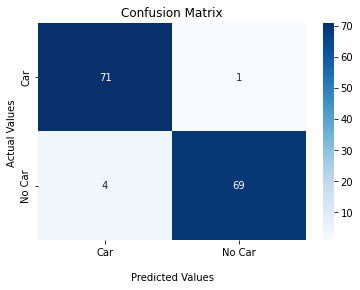

In [24]:
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt='g') # setup chart
ax.set_title('Confusion Matrix'); # set chart title
ax.set_xlabel('\nPredicted Values') #set x axis labels 
ax.set_ylabel('Actual Values '); #set y axis labels
ax.xaxis.set_ticklabels(['Car','No Car']) #set labels 
ax.yaxis.set_ticklabels(['Car','No Car']) #set labels 
plt.show() #display the chart

In [25]:
model.save("mask_detector.model", save_format="h5") #save model in h5 format

Package    Version

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.



---------- -------
pip        22.0.4
pywin32    304
setuptools 58.1.0
wcwidth    0.2.5
